# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os
import sklearn

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


As we can see in the dataframe above, we have several rows (measurements) for the same target. To make the best possible analysis, we would like to use the measurements with most values for each target.

That's why we first count the number of values for each row and then filter the targets for the rows with most values.

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

We need at least two data points to conclude any kind of correlation

In [6]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [7]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


See which Targets are left in our data frame.

In [8]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [9]:
# create empty dictionary
target_dfs = {}

In [10]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [11]:
# example of Target with more than one Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [12]:
# find row with maximum amount of data points for each target
max_dfrows = {}

for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [13]:
frames = list(max_dfrows[target] for target in targets)

In [14]:
merged_df = pd.concat(frames, axis=0)

In [15]:
units = list(set(merged_df['Unit']))

We know that most of our Indicators are given in the unit 'percent', but we want to see here what are other units

In [16]:
units.remove('Percent')
units

['Constant USD', 'USD', 'Metric Tons']

Which and how many Indicators are expressed in other units than 'percent'?

In [17]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15


### Clean up data frame

To prepare the dataframe for the actual analysis, we remove unused columns and transpose the dataframe, having years of measurements as rows and targets as columns.

In [18]:
# Drop unused columns
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

# transpose
final_t = final_df.T

targets = list(final_t.columns)

Normalize the data set to reduce any covariate shift

In [19]:
def normalize_df(df):
    return (df -df.mean())/df.std()

In [20]:
final_t = normalize_df(final_t)

In [21]:
# shuffle data
final_t_shuffled = sklearn.utils.shuffle(final_t, random_state=200)

### Structure Learning

We learn the structure of the network by deploying linear regression and calculate error measurements. In detail, we say that a correlation between two Targets exists, if the (standardized) correlation coefficient is higher than 0.9.

In [22]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

In [23]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    
    if len(trues)>2:
        rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
        r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    else:
        rae = np.nan
        r2 = np.nan
    return mae, rae, rmse, r2

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


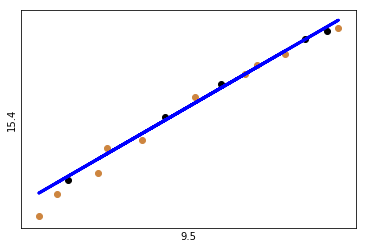

9.5 15.4
MAE: 0.12440
RMSE: 0.15691
R2: 0.972
Coefficient 0.9031785631711373
--------------------------




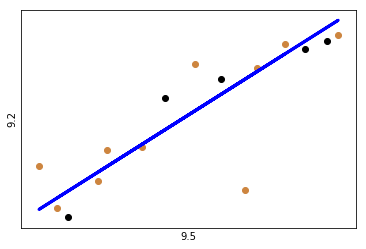

9.5 9.2
MAE: 0.38389
RMSE: 0.59469
R2: 0.555
Coefficient 0.9230764173180971
--------------------------


9.5 3.6
MAE: 1.43774
RMSE: 1.95252
R2: nan
Coefficient -1.34414085516827
--------------------------


9.5 4.2
MAE: 0.32983
RMSE: 0.37901
R2: 0.833
Coefficient 1.3416557779861082
--------------------------




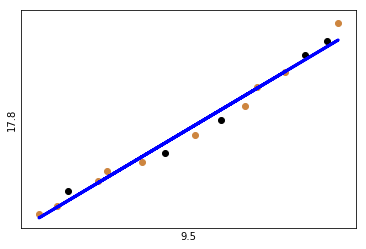

9.5 17.8
MAE: 0.08920
RMSE: 0.11761
R2: 0.982
Coefficient 0.9018945485960708
--------------------------


9.5 8.2
MAE: 0.93076
RMSE: 1.14613
R2: 0.000
Coefficient -0.059789800025135766
--------------------------




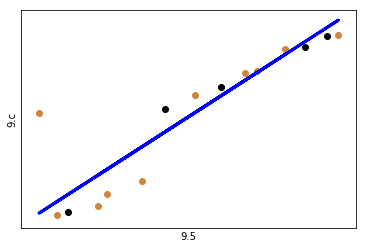

9.5 9.c
MAE: 0.36444
RMSE: 0.53659
R2: 0.685
Coefficient 0.9557834695318664
--------------------------


9.5 6.1
MAE: 0.24453
RMSE: 0.27470
R2: 0.926
Coefficient 0.8938107454779809
--------------------------


9.5 17.19
MAE: 1.22166
RMSE: 1.35177
R2: 0.000
Coefficient 0.2226967324463827
--------------------------


9.5 2.1
MAE: 0.13648
RMSE: 0.16621
R2: 0.928
Coefficient -0.6599776881585805
--------------------------


9.5 17.2
MAE: 0.32454
RMSE: 0.40380
R2: 0.807
Coefficient 0.6943992205888336
--------------------------


9.5 15.1
MAE: 0.28076
RMSE: 0.32132
R2: 0.897
Coefficient 0.8690264945869126
--------------------------


9.5 8.1
MAE: 0.87925
RMSE: 1.14919
R2: 0.004
Coefficient -0.09573597297973796
--------------------------


9.5 10.c
MAE: 0.54602
RMSE: 0.59105
R2: nan
Coefficient -3.072810754449695
--------------------------




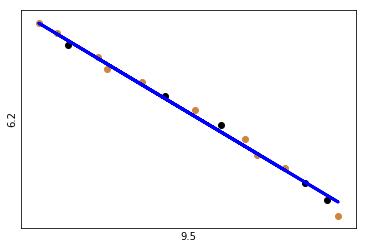

9.5 6.2
MAE: 0.06202
RMSE: 0.08373
R2: 0.991
Coefficient -0.909344737992069
--------------------------


9.5 12.2
MAE: 0.24908
RMSE: 0.29219
R2: 0.897
Coefficient 1.4565766850612982
--------------------------




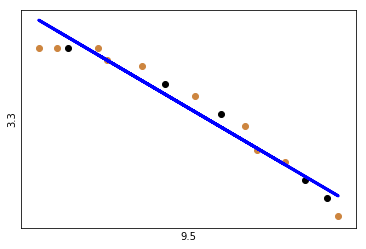

9.5 3.3
MAE: 0.18975
RMSE: 0.23249
R2: 0.928
Coefficient -0.9320193435702896
--------------------------


9.5 7.2
MAE: 0.64489
RMSE: 0.73958
R2: 0.358
Coefficient 0.8385773299941104
--------------------------


9.5 14.4
MAE: 0.59173
RMSE: 0.64033
R2: 0.523
Coefficient 0.7485005411121101
--------------------------


9.5 8.4
MAE: 0.24908
RMSE: 0.29219
R2: 0.897
Coefficient 1.4565766850612982
--------------------------


9.5 17.3
MAE: 0.21939
RMSE: 0.30368
R2: 0.899
Coefficient 0.7847527893650187
--------------------------


9.5 7.1
MAE: 0.08977
RMSE: 0.11913
R2: nan
Coefficient 0.8269159981686063
--------------------------




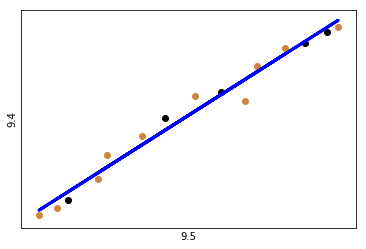

9.5 9.4
MAE: 0.14794
RMSE: 0.16655
R2: 0.970
Coefficient 0.9865437079530124
--------------------------


15.4 3.1
MAE: 0.09488
RMSE: 0.09606
R2: nan
Coefficient -0.7681423460125293
--------------------------


15.4 9.2
MAE: 0.40024
RMSE: 0.63261
R2: 0.525
Coefficient 1.0966156722630636
--------------------------


15.4 3.6
MAE: 1.69357
RMSE: 2.20051
R2: nan
Coefficient -1.4605258942117922
--------------------------


15.4 4.2
MAE: 0.44826
RMSE: 0.53239
R2: 0.671
Coefficient 1.5824124876898662
--------------------------


15.4 17.8
MAE: 0.21765
RMSE: 0.26387
R2: 0.911
Coefficient 1.1074147893315365
--------------------------


15.4 8.2
MAE: 0.85613
RMSE: 1.10328
R2: 0.000
Coefficient -0.13287870443029937
--------------------------


15.4 9.c
MAE: 0.33914
RMSE: 0.61456
R2: 0.587
Coefficient 1.0452380825578427
--------------------------




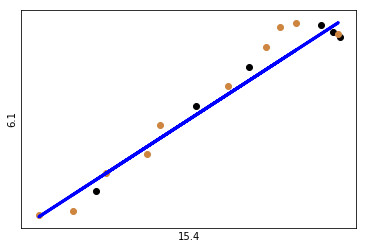

15.4 6.1
MAE: 0.19665
RMSE: 0.24406
R2: 0.942
Coefficient 0.94154015867398
--------------------------


15.4 17.19
MAE: 1.22539
RMSE: 1.35765
R2: 0.000
Coefficient 0.27196612136662396
--------------------------


15.4 2.1
MAE: 0.18265
RMSE: 0.25565
R2: 0.829
Coefficient -0.7593277061045541
--------------------------


15.4 17.2
MAE: 0.27085
RMSE: 0.37449
R2: 0.835
Coefficient 1.021169087640454
--------------------------




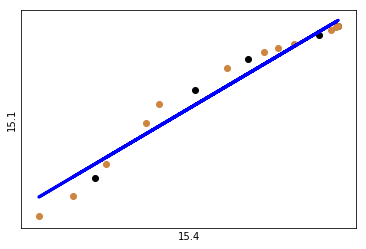

15.4 15.1
MAE: 0.17402
RMSE: 0.19979
R2: 0.961
Coefficient 0.9468755445505255
--------------------------


15.4 14.5
MAE: 31.68799
RMSE: 36.29615
R2: 0.000
Coefficient 19.18264953272293
--------------------------


15.4 8.1
MAE: 0.86223
RMSE: 1.15516
R2: 0.000
Coefficient -0.048930816566006834
--------------------------


15.4 10.c
MAE: 1.84248
RMSE: 2.21084
R2: 0.000
Coefficient -14.006684964699508
--------------------------


15.4 6.2
MAE: 0.18580
RMSE: 0.22088
R2: 0.939
Coefficient -1.1022244446724396
--------------------------


15.4 12.2
MAE: 0.22897
RMSE: 0.28144
R2: 0.904
Coefficient 1.4024335075085452
--------------------------


15.4 3.3
MAE: 0.31138
RMSE: 0.39446
R2: 0.794
Coefficient -1.1318151500375626
--------------------------


15.4 7.2
MAE: 0.71627
RMSE: 0.82794
R2: 0.196
Coefficient 0.8762400754990606
--------------------------


15.4 14.4
MAE: 0.71864
RMSE: 0.73295
R2: 0.375
Coefficient 0.8991469918411161
--------------------------


15.4 16.a
MAE: 23.43373
RMSE: 26.6

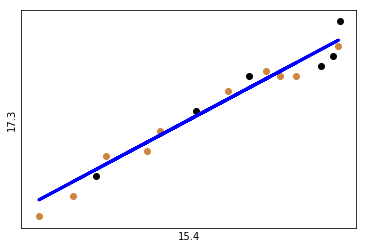

15.4 17.3
MAE: 0.15751
RMSE: 0.17052
R2: 0.968
Coefficient 0.9679870517481235
--------------------------




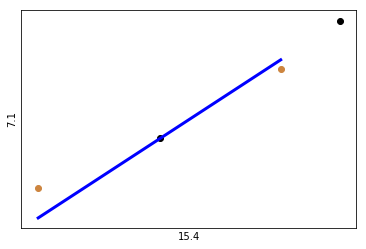

15.4 7.1
MAE: 0.26745
RMSE: 0.30264
R2: nan
Coefficient 0.9258973056119334
--------------------------


15.4 3.9
MAE: 0.18710
RMSE: 0.24335
R2: nan
Coefficient -0.669367034303834
--------------------------


15.4 9.4
MAE: 0.15440
RMSE: 0.18554
R2: 0.963
Coefficient 1.0942693725829544
--------------------------


3.1 9.2
MAE: 0.56188
RMSE: 0.72877
R2: nan
Coefficient -1.3338504362198493
--------------------------


3.1 17.8
MAE: 0.60516
RMSE: 0.70139
R2: nan
Coefficient -1.7746587937038723
--------------------------


3.1 8.2
MAE: 1.11253
RMSE: 1.22419
R2: nan
Coefficient 0.6928389110748264
--------------------------


3.1 9.c
MAE: 1.45785
RMSE: 1.82163
R2: nan
Coefficient -1.5970822553962094
--------------------------




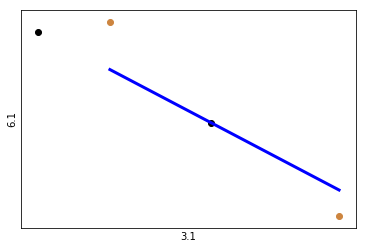

3.1 6.1
MAE: 0.50190
RMSE: 0.52229
R2: nan
Coefficient -0.927825820267653
--------------------------


3.1 2.1
MAE: 0.59715
RMSE: 0.75569
R2: nan
Coefficient 1.211752739769449
--------------------------


3.1 17.2
MAE: 0.85716
RMSE: 1.08358
R2: nan
Coefficient -0.5731612835865451
--------------------------




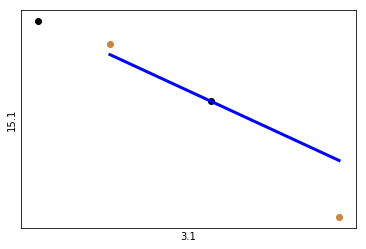

3.1 15.1
MAE: 0.50557
RMSE: 0.60930
R2: nan
Coefficient -0.909519447353561
--------------------------


3.1 14.5
MAE: 0.61476
RMSE: 0.77527
R2: nan
Coefficient -1.350270648321205
--------------------------


3.1 8.1
MAE: 0.32631
RMSE: 0.46032
R2: nan
Coefficient 0.44360601120067766
--------------------------


3.1 6.2
MAE: 0.48785
RMSE: 0.55589
R2: nan
Coefficient 1.6836471876888013
--------------------------


3.1 3.3
MAE: 0.86714
RMSE: 1.11705
R2: nan
Coefficient 1.8940595594870808
--------------------------


3.1 16.a
MAE: 0.40194
RMSE: 0.52239
R2: nan
Coefficient -0.6898311305707241
--------------------------


3.1 3.4
MAE: 0.13611
RMSE: 0.15590
R2: nan
Coefficient 1.0547293387864844
--------------------------


3.1 17.3
MAE: 0.11505
RMSE: 0.12346
R2: nan
Coefficient -1.4451471044362951
--------------------------


3.1 3.9
MAE: 0.16868
RMSE: 0.19839
R2: nan
Coefficient 0.871410146541922
--------------------------


9.2 3.6
MAE: 1.13273
RMSE: 1.33480
R2: nan
Coefficient -1.609129376

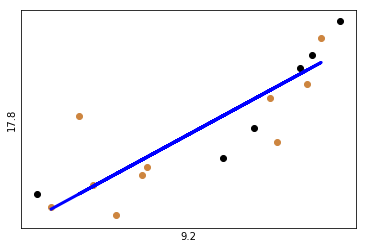

9.2 17.8
MAE: 0.40281
RMSE: 0.56218
R2: 0.595
Coefficient 0.9545872364911525
--------------------------


9.2 8.2
MAE: 0.88012
RMSE: 1.10527
R2: 0.000
Coefficient 0.016109760188846856
--------------------------




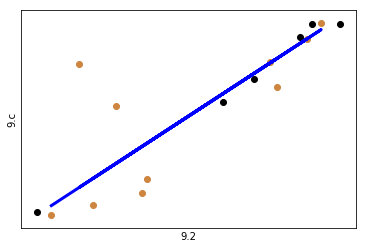

9.2 9.c
MAE: 0.45766
RMSE: 0.66334
R2: 0.518
Coefficient 0.9747028691282287
--------------------------


9.2 6.1
MAE: 0.46779
RMSE: 0.67089
R2: 0.559
Coefficient 0.8649799906792499
--------------------------


9.2 17.19
MAE: 1.11709
RMSE: 1.30305
R2: 0.000
Coefficient 0.43414621224821365
--------------------------


9.2 2.1
MAE: 0.31895
RMSE: 0.42878
R2: 0.520
Coefficient -0.644406681512749
--------------------------




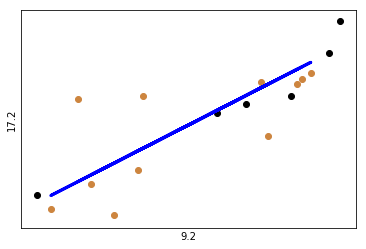

9.2 17.2
MAE: 0.51678
RMSE: 0.67008
R2: 0.471
Coefficient 0.9399562700491232
--------------------------


9.2 15.1
MAE: 0.40255
RMSE: 0.63925
R2: 0.600
Coefficient 0.8524917288276556
--------------------------


9.2 14.5
MAE: 0.69906
RMSE: 0.82575
R2: 0.000
Coefficient 1.5259766287429506
--------------------------


9.2 8.1
MAE: 0.87261
RMSE: 1.16234
R2: 0.000
Coefficient 0.03956639511038993
--------------------------


9.2 10.c
MAE: 0.11558
RMSE: 0.16059
R2: 0.883
Coefficient -6.772767518845678
--------------------------




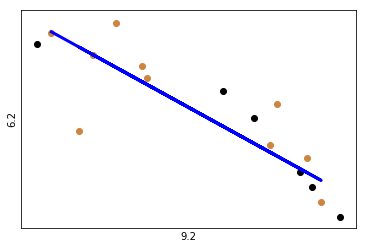

9.2 6.2
MAE: 0.39745
RMSE: 0.57605
R2: 0.586
Coefficient -0.9664893505480944
--------------------------


9.2 12.2
MAE: 0.48226
RMSE: 0.73341
R2: 0.350
Coefficient 1.0899953580212125
--------------------------




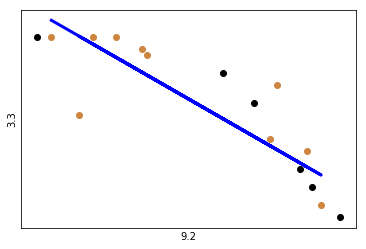

9.2 3.3
MAE: 0.44067
RMSE: 0.56567
R2: 0.576
Coefficient -0.9711278360815199
--------------------------


9.2 7.2
MAE: 0.73637
RMSE: 0.88122
R2: 0.089
Coefficient 0.5818043836055695
--------------------------


9.2 14.4
MAE: 1.46087
RMSE: 1.75021
R2: 0.000
Coefficient 1.469942118314277
--------------------------


9.2 16.a
MAE: 0.50201
RMSE: 0.66926
R2: 0.370
Coefficient 1.1296142175002688
--------------------------


9.2 3.4
MAE: 0.52031
RMSE: 0.56923
R2: nan
Coefficient -0.790740333508157
--------------------------


9.2 8.4
MAE: 0.48226
RMSE: 0.73341
R2: 0.350
Coefficient 1.0899953580212125
--------------------------




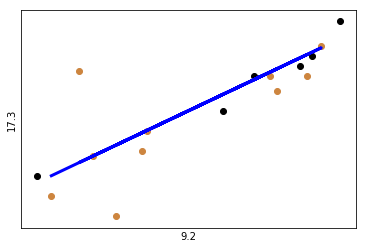

9.2 17.3
MAE: 0.43663
RMSE: 0.67868
R2: 0.494
Coefficient 0.9038444048178927
--------------------------




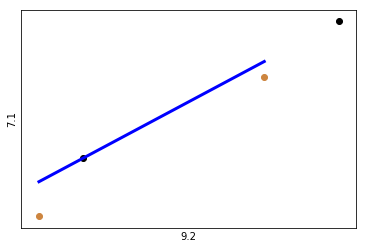

9.2 7.1
MAE: 0.29007
RMSE: 0.30911
R2: nan
Coefficient 0.993523828183931
--------------------------


9.2 3.9
MAE: 0.47189
RMSE: 0.66708
R2: nan
Coefficient -0.6533042407749331
--------------------------




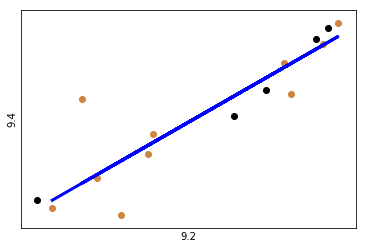

9.2 9.4
MAE: 0.32356
RMSE: 0.50725
R2: 0.721
Coefficient 0.9897179661872847
--------------------------


3.6 17.8
MAE: 0.94890
RMSE: 1.27760
R2: nan
Coefficient -0.7396956732747297
--------------------------


3.6 8.2
MAE: 0.98236
RMSE: 1.10493
R2: nan
Coefficient 0.2881645257312029
--------------------------


3.6 9.c
MAE: 0.30631
RMSE: 0.31879
R2: nan
Coefficient -0.8671357201803429
--------------------------


3.6 6.1
MAE: 1.31440
RMSE: 1.48707
R2: nan
Coefficient -0.5356363032142091
--------------------------


3.6 2.1
MAE: 0.59801
RMSE: 0.69319
R2: nan
Coefficient 0.5922963994530966
--------------------------


3.6 17.2
MAE: 1.16479
RMSE: 1.59537
R2: nan
Coefficient -0.1255798469028086
--------------------------


3.6 15.1
MAE: 1.30204
RMSE: 1.69774
R2: nan
Coefficient -0.4719374133266416
--------------------------


3.6 8.1
MAE: 0.84446
RMSE: 0.84674
R2: nan
Coefficient 0.3409418230088114
--------------------------


3.6 6.2
MAE: 0.98652
RMSE: 1.33928
R2: nan
Coefficient 0.719195

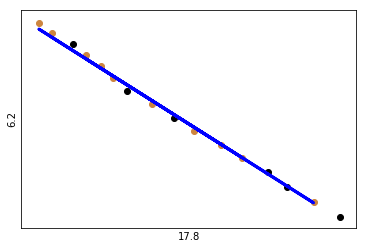

17.8 6.2
MAE: 0.04687
RMSE: 0.05558
R2: 0.996
Coefficient -0.9789785504316588
--------------------------


17.8 12.2
MAE: 0.32831
RMSE: 0.41060
R2: 0.796
Coefficient 1.9288347826555439
--------------------------


17.8 3.3
MAE: 0.12255
RMSE: 0.16056
R2: 0.966
Coefficient -1.0219737132850095
--------------------------


17.8 7.2
MAE: 0.62876
RMSE: 0.71744
R2: 0.396
Coefficient 1.0218089157008206
--------------------------


17.8 14.4
MAE: 0.50343
RMSE: 0.58831
R2: 0.597
Coefficient 0.7143604966725084
--------------------------


17.8 16.a
MAE: 0.63717
RMSE: 0.79265
R2: nan
Coefficient 0.38871197833527465
--------------------------


17.8 3.4
MAE: 0.28675
RMSE: 0.36359
R2: nan
Coefficient -0.5943279590017242
--------------------------


17.8 8.4
MAE: 0.32831
RMSE: 0.41060
R2: 0.796
Coefficient 1.9288347826555439
--------------------------


17.8 17.3
MAE: 0.29951
RMSE: 0.38363
R2: 0.838
Coefficient 0.8189482620073496
--------------------------


17.8 7.1
MAE: 0.08149
RMSE: 0.08150
R2: na

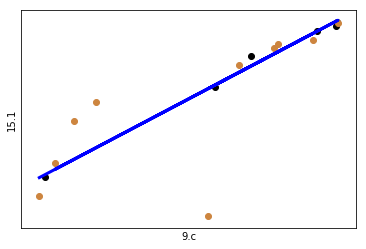

9.c 15.1
MAE: 0.40619
RMSE: 0.68627
R2: 0.531
Coefficient 0.9110597633863885
--------------------------


9.c 14.5
MAE: 0.76021
RMSE: 0.82049
R2: nan
Coefficient 0.8454609296164429
--------------------------


9.c 8.1
MAE: 0.87822
RMSE: 1.17415
R2: 0.000
Coefficient 0.015140982832537364
--------------------------


9.c 10.c
MAE: 1.21333
RMSE: 1.29265
R2: 0.000
Coefficient -14.232408876045252
--------------------------


9.c 6.2
MAE: 0.42070
RMSE: 0.55987
R2: 0.609
Coefficient -1.0016262229429853
--------------------------


9.c 12.2
MAE: 0.58385
RMSE: 0.78624
R2: 0.253
Coefficient 1.1585232669942755
--------------------------


9.c 3.3
MAE: 0.41075
RMSE: 0.48686
R2: 0.686
Coefficient -1.014288358715561
--------------------------


9.c 7.2
MAE: 0.52324
RMSE: 0.65683
R2: 0.494
Coefficient 0.6818234554252327
--------------------------


9.c 14.4
MAE: 0.90158
RMSE: 1.00360
R2: 0.000
Coefficient 1.11372993986574
--------------------------


9.c 16.a
MAE: 0.96336
RMSE: 1.30056
R2: nan
Coeffi

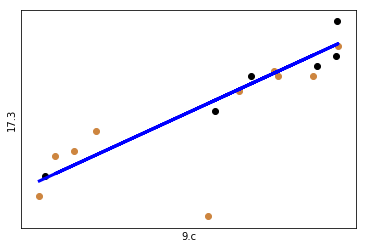

9.c 17.3
MAE: 0.37542
RMSE: 0.66310
R2: 0.517
Coefficient 0.9120865671364566
--------------------------


9.c 7.1
MAE: 0.83273
RMSE: 1.01352
R2: nan
Coefficient 0.7458232460481491
--------------------------


9.c 3.9
MAE: 0.89987
RMSE: 1.18086
R2: nan
Coefficient -0.5456263405329362
--------------------------


9.c 9.4
MAE: 0.37857
RMSE: 0.59153
R2: 0.620
Coefficient 1.0051397682106997
--------------------------


6.1 17.19
MAE: 1.22578
RMSE: 1.34511
R2: 0.000
Coefficient 0.3255249988944013
--------------------------


6.1 2.1
MAE: 0.28070
RMSE: 0.31082
R2: 0.748
Coefficient -0.7496696655656742
--------------------------


6.1 17.2
MAE: 0.25690
RMSE: 0.32096
R2: 0.878
Coefficient 0.8755253919357887
--------------------------


6.1 15.1
MAE: 0.19810
RMSE: 0.22423
R2: 0.950
Coefficient 1.0036633387030245
--------------------------


6.1 14.5
MAE: 1.34518
RMSE: 1.37047
R2: nan
Coefficient 1.455306177976042
--------------------------


6.1 8.1
MAE: 0.86657
RMSE: 1.15504
R2: 0.000
Coefficie

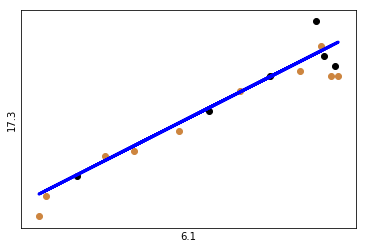

6.1 17.3
MAE: 0.21758
RMSE: 0.29100
R2: 0.907
Coefficient 0.986169501965795
--------------------------


6.1 7.1
MAE: 0.83735
RMSE: 0.84033
R2: nan
Coefficient 1.2504131723673149
--------------------------




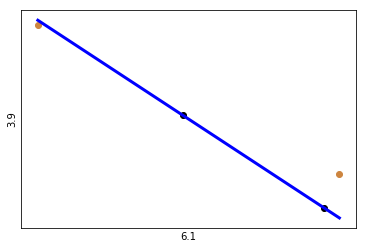

6.1 3.9
MAE: 0.30270
RMSE: 0.38638
R2: nan
Coefficient -0.9391958355831733
--------------------------


6.1 9.4
MAE: 0.22103
RMSE: 0.27689
R2: 0.917
Coefficient 1.0754468996463775
--------------------------


17.19 2.1
MAE: 0.77485
RMSE: 0.85974
R2: 0.000
Coefficient -0.8186110591410881
--------------------------


17.19 17.2
MAE: 0.24838
RMSE: 0.32802
R2: 0.218
Coefficient 0.2221811958927685
--------------------------


17.19 15.1
MAE: 0.73472
RMSE: 0.81219
R2: 0.000
Coefficient 0.7209432697159199
--------------------------


17.19 8.1
MAE: 3.91868
RMSE: 4.07482
R2: 0.000
Coefficient -2.3786301118963955
--------------------------


17.19 10.c
MAE: 0.75912
RMSE: 0.77504
R2: nan
Coefficient -0.33462782173086675
--------------------------


17.19 6.2
MAE: 0.59798
RMSE: 0.64880
R2: 0.000
Coefficient -0.6786994137982603
--------------------------


17.19 12.2
MAE: 0.24871
RMSE: 0.28984
R2: 0.000
Coefficient 0.6400032571401009
--------------------------


17.19 3.3
MAE: 0.64454
RMSE: 0.7073

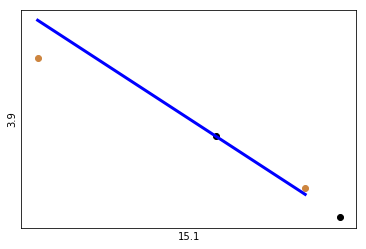

15.1 3.9
MAE: 0.31570
RMSE: 0.38559
R2: nan
Coefficient -0.958099520661679
--------------------------


15.1 9.4
MAE: 0.23474
RMSE: 0.27664
R2: 0.917
Coefficient 1.0821165064660938
--------------------------


14.5 8.1
MAE: 0.47986
RMSE: 0.49570
R2: nan
Coefficient -0.32853118132443604
--------------------------


14.5 6.2
MAE: 0.32248
RMSE: 0.42622
R2: nan
Coefficient -1.2468960869304861
--------------------------


14.5 3.3
MAE: 0.04161
RMSE: 0.04188
R2: nan
Coefficient -1.4027258622869199
--------------------------


14.5 16.a
MAE: 0.52757
RMSE: 0.56901
R2: 0.545
Coefficient 0.7402565650240711
--------------------------


14.5 3.4
MAE: 0.44498
RMSE: 0.56250
R2: nan
Coefficient -0.7811243916897935
--------------------------


14.5 17.3
MAE: 0.62059
RMSE: 0.87240
R2: nan
Coefficient 1.070264769683804
--------------------------


14.5 3.9
MAE: 0.56543
RMSE: 0.69800
R2: nan
Coefficient -0.6453596155891771
--------------------------


8.1 10.c
MAE: 1.36447
RMSE: 1.90798
R2: 0.000
Coeffic

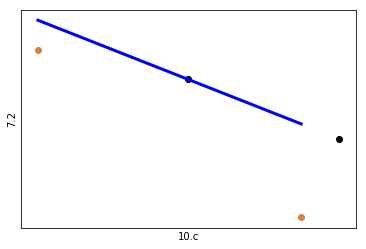

10.c 7.2
MAE: 0.63134
RMSE: 0.71080
R2: nan
Coefficient -0.9307200492406918
--------------------------


10.c 17.3
MAE: 0.11044
RMSE: 0.13841
R2: 0.595
Coefficient -0.3195124263197471
--------------------------


10.c 9.4
MAE: 0.10248
RMSE: 0.10339
R2: nan
Coefficient -0.2553582397205941
--------------------------


6.2 12.2
MAE: 0.27786
RMSE: 0.33801
R2: 0.862
Coefficient -1.7420565045273628
--------------------------


6.2 3.3
MAE: 0.14655
RMSE: 0.19978
R2: 0.947
Coefficient 1.038437108197621
--------------------------




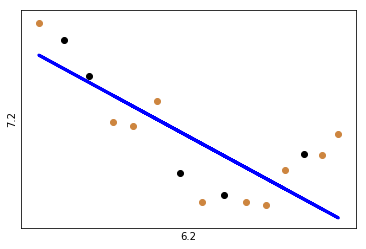

6.2 7.2
MAE: 0.64134
RMSE: 0.73169
R2: 0.372
Coefficient -0.972620310763738
--------------------------


6.2 14.4
MAE: 0.55094
RMSE: 0.62248
R2: 0.549
Coefficient -0.7654780550471652
--------------------------


6.2 16.a
MAE: 0.60182
RMSE: 0.74720
R2: nan
Coefficient -0.4097242792996783
--------------------------


6.2 3.4
MAE: 0.24296
RMSE: 0.29624
R2: nan
Coefficient 0.6264550830476227
--------------------------


6.2 8.4
MAE: 0.27786
RMSE: 0.33801
R2: 0.862
Coefficient -1.7420565045273628
--------------------------


6.2 17.3
MAE: 0.25598
RMSE: 0.33167
R2: 0.879
Coefficient -0.8499851703349375
--------------------------


6.2 7.1
MAE: 0.05737
RMSE: 0.06046
R2: nan
Coefficient -0.7978678300733478
--------------------------


6.2 3.9
MAE: 0.42118
RMSE: 0.48593
R2: nan
Coefficient 0.517572893486156
--------------------------


6.2 9.4
MAE: 0.16463
RMSE: 0.18606
R2: 0.962
Coefficient -1.072184713178992
--------------------------


12.2 3.3
MAE: 0.24157
RMSE: 0.27823
R2: 0.769
Coefficien

In [24]:
keptPairs = list()
processedPairs = list()
discardedPairs = list()
edgecolor = list()
pairsAndRel = {}

n_connections = 0

for targetx in targets:     #loop over all targets
        
        for targety in targets:
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/validation sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X_valid)
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        
                        
                        coef = linreg.coef_[0][0]
                        
                        # filter out independant variables (coefficient close to 0, coefficient > 100)
                        if (0.9 < np.abs(coef) < 1):
                            
                            keptPairs.extend([tuple((targetx, targety))])

                            if coef > 0: edge_color = 'g'#edgecolor.append('g')
                            else: edge_color = 'r'
                                    
                            edgecolor.append(edge_color)
                            pairsAndRel[targetx, targety] = edge_color

                            plt.scatter(X_train, Y_train,  color='black')
                            plt.scatter(X_valid, Y_valid, color='peru')
                            plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                            plt.xticks(())
                            plt.yticks(())
                            plt.xlabel(targetx)
                            plt.ylabel(targety)
                            plt.show()

                            n_connections = n_connections + 1

                        else: discardedPairs.extend([[targetx, targety]])

                        print(targetx, targety)
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))
                        print('Coefficient', coef)
                        print('--------------------------')
                        print('\n')

#print(keptPairs)

In [25]:
print("Total number of connections found: ", n_connections)

Total number of connections found:  29


In [26]:
#print(keptPairs)
#print(discardedPairs)

### Graphical Models

In [27]:
import networkx as nx

In [28]:
G1 = nx.Graph()
G1.add_edges_from(keptPairs)

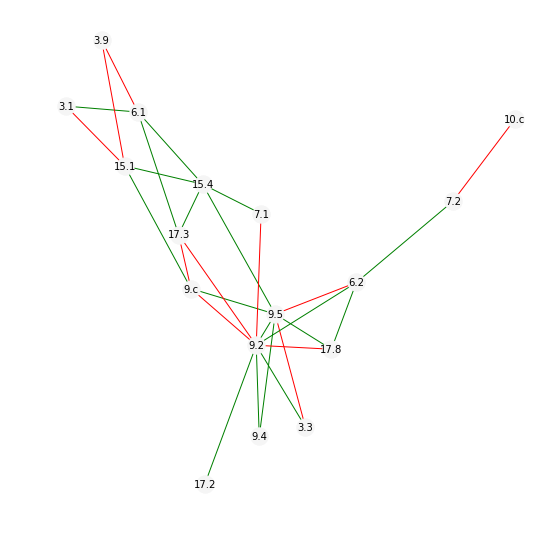

In [29]:
pos2 = nx.spring_layout(G1) # choose layout

plt.figure(1,figsize=(7,7)) 
nx.draw(G1,pos2, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.savefig("structure.png")
plt.show()

In this plot, the most connected and therefore most influential nodes are located in the middle of the graph and are plotted closer together. There are also some targets that are only connected to one other target.

Positive interconnections are indicated by a green, negative by a red edge.

In [30]:
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

size = 1024,1024
circles = Image.open("Circle-Designs-01.png")
circles = circles.resize(size, Image.ANTIALIAS)
plot = Image.open("structure.png")
plot = plot.resize(size, Image.ANTIALIAS)
overlay = Image.blend(circles, plot,alpha=0.7)
#overlay.show()
#overlay.save("final.png")

To extract the cliques (complete subgraphs of the graph) that already are visible in the graph above, we use networkx' inbuilt function find_cliques(G).

We would like to make our imputations first on one of these cliques, actually on one that has the most members.


In [31]:
clique_list = list(nx.find_cliques(G1))
clique_list

[['7.2', '10.c'],
 ['7.2', '6.2'],
 ['15.1', '15.4'],
 ['15.1', '3.9'],
 ['15.1', '9.c'],
 ['15.1', '3.1'],
 ['15.4', '7.1'],
 ['15.4', '6.1', '17.3'],
 ['15.4', '9.5'],
 ['3.1', '6.1'],
 ['6.1', '3.9'],
 ['9.2', '7.1'],
 ['9.2', '17.3', '9.c'],
 ['9.2', '9.5', '9.4'],
 ['9.2', '9.5', '3.3'],
 ['9.2', '9.5', '9.c'],
 ['9.2', '9.5', '6.2', '17.8'],
 ['9.2', '17.2']]

In [32]:
# finding clique containing most nodes
length = 0
for c in clique_list:
    if len(c) > length:
        length = len(c)
        max_clique = c

In [33]:
import itertools

def complete_graph_from_list(L, create_using=None):
    G = nx.empty_graph()
    if len(L)>1:
        if G.is_directed():
            edges = itertools.permutations(L,2)
        else:
            edges = itertools.combinations(L,2)
        G.add_edges_from(edges)
    return G


In [34]:
cliqueGraph = complete_graph_from_list(max_clique)

In [35]:
cliqueGraph_edges = list(cliqueGraph.edges)
pairsDictListKeys = list(pairsAndRel.keys())

In [36]:
clique_e_color = []
for edge in cliqueGraph_edges:
    if edge in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge])
    elif edge[::-1] in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge[::-1]])

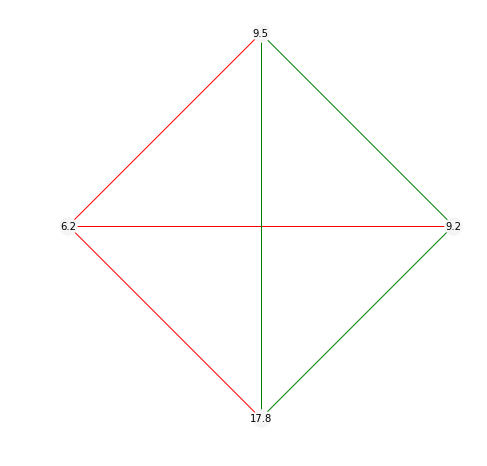

In [37]:
#cliqueGraph.add_nodes_from(max_clique)
pos9 = nx.shell_layout(cliqueGraph)
plt.figure(1,figsize=(6,6)) 
nx.draw(cliqueGraph,pos9, with_labels=True, font_size=10, edge_color=clique_e_color, node_color='whitesmoke')
plt.show()

In [38]:
print('Our max clique consists of the following targets: ', cliqueGraph.nodes)

Our max clique consists of the following targets:  ['9.2', '9.5', '6.2', '17.8']


# 2. Build temporal model to infer missing observations

We have a temporal model with missing observations as NaNs, and want to infer them according to their correlated targets and their own time series development. Therefore, we design a linear dynamical system with inputs, including an autoregressive model of order 2.

## Define STAN model

From now on, we can actually forget all information we've gotten so far. With the implementation in STAN, we will gain insights for the following two questions in one single model (wow - so amazing :-) ):

**1. How are Targets correlated?**

**2. What are expectable values for missing observations (imputing)?**

Note that we observe two time-series simultaneously. We will model the correlations between the two time-series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or (equivalent):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the model described above is the **covariance matrix $\boldsymbol\Sigma$** which embodies the object that will allow us to capture the correlations between the two time-series.

In STAN, the recommended approach is to decompose the covariance matrix $\boldsymbol\Sigma$ into a *scale* and a *matrix*, but we are able to do so in a more natural way based on the actual variable scales and a correlation matrix. Specifically, we define:

\begin{align}
\boldsymbol\Sigma = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag_matrix}(\boldsymbol\tau)
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

Similar to any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but something weakly informative like a half-Cauchy distribution with a small scale is recommended, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0) , \, \mbox{with the constraint:} \, \boldsymbol\tau > 0
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, the STAN manual recommends a LKJ prior like:

\begin{align}
\boldsymbol\Omega ∼ LKJCorr(10.0)
\end{align}

Finally, we can define a multivariate Gaussian with parameters $\boldsymbol\mu$, $\boldsymbol\tau$ and $\boldsymbol\Omega$ using:

    multi_normal(mu, quad_form_diag(Omega, tau))


To impute missing observations, we do

\begin{align}
y_{t} &\sim \mathcal{N} \Big(\beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{T} y_{t-T} \Big)
\end{align}


**Note** that we want to make the missing observation dependent on two previous observations. This is equivalent to define an autoregressive model of order 2.

<img src="pgm.png">

In [39]:
SDG_STAN="""
data {
    int<lower = 0> N_obs1;
    int<lower = 0> N_mis1;    // how many do we want to infer
    int<lower = 0> N_obs2;  
    int<lower = 0> N_mis2;
    int<lower = 1, upper = N_obs1 + N_mis1> ix_obs1[N_obs1];    // index for observed time steps of target 1
    int<lower = 1, upper = N_obs1 + N_mis1> ix_mis1[N_mis1];
    int<lower = 1, upper = N_obs2 + N_mis2> ix_obs2[N_obs2];    // index for observed time steps of target 2
    int<lower = 1, upper = N_obs2 + N_mis2> ix_mis2[N_mis2];
    real y_obs1[N_obs1];         // observed time-series data for target 1
    real y_obs2[N_obs2];         // observed time-series data for target 2
}

transformed data {
    int<lower = 0> T = N_obs1 + N_mis1;  // length of the time-series
}

parameters {
    vector[2] beta[2];            // state transition coefficients 
    corr_matrix[2] Omega;       // gives us the correlation with **Omega[1,2]=Omega[2,1]=Cov(1,2)**; Omega[1,1]=Var(1);Omega[2,2]=Var(2)    1 is target 1, 2 is target 2
    vector<lower=0>[2] tau;     // uncertainty in the latent space
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis1];        // missing time-series data to infer for target 1
    real y_mis2[N_mis2];        // missing time-series data to infer for target 2
}

transformed parameters {
    real y1[T];
    real y2[T];
    matrix[2,2] L_sigma;
    y1[ix_obs1] = y_obs1;
    y1[ix_mis1] = y_mis1;
    y2[ix_obs2] = y_obs2;
    y2[ix_mis2] = y_mis2;
}

model {
    for(i in 1:2)                   
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(1);         // STAN manual Section 63.1 (recommendation is lkj_corr)
    sigma ~ cauchy(0,5);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first latent state
    z[2,:] ~ normal(0,1);           // prior on second latent state
    
    for(t in 3:T) {
        vector[2] mu;                          // mu is a vector of the means of our multivariate normal 
        mu[1] = beta[1]' * z[(t-2):(t-1),1];   // mu[1] is the mean of target 1 
        mu[2] = beta[2]' * z[(t-2):(t-1),2];   // mu[2] is the mean of target 2
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood for target 1
    y2 ~ normal(z[:,2], sigma);    // likelihood for target 2
}
"""

### What targets are in our clique?

We will work for the rest of the notebook with this single clique.

In [40]:
clique_nodes = list(cliqueGraph.nodes)
clique_nodes

['9.2', '9.5', '6.2', '17.8']

In [41]:
clique_df_t = final_t[clique_nodes]

In [42]:
clique_df_t = clique_df_t[clique_df_t.index > '1990']

In [43]:
g1_nodes = list(G1.nodes)
g1_df_t = final_t[g1_nodes]
g1_df_t = g1_df_t[g1_df_t.index > '1990']

## What is observed, what is missing?

- N_obs: Number of observed values (length of loc array)
- N_mis: Number of missing values (length of loc array)
- ix_obs: indices of observed values
- ix_mis: indices of missing values
- y_obs: observed values

In [44]:
# prepare data for STAN model
def prepareInputData(df, target1, target2):
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
    
    ix_obs1 = np.where(~np.isnan(t1_list))[0]
    ix_obs2 = np.where(~np.isnan(t2_list))[0]
    
    ix_mis1 = np.where(np.isnan(t1_list))[0]
    ix_mis2 = np.where(np.isnan(t2_list))[0]
    
    y_obs1 = [t1_list[index] for index in ix_obs1]
    y_obs2 = [t2_list[index] for index in ix_obs2]
    
    N_obs1 = len(ix_obs1)
    N_obs2 = len(ix_obs2)
    
    N_mis1 = len(ix_mis1)
    N_mis2 = len(ix_mis2)
    
    data = {'N_obs1': N_obs1, 'N_mis1': N_mis1, 'N_obs2': N_obs2, 'N_mis2': N_mis2,
            'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
            'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}
    
    return data

In [45]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c8db35d3d6b106a2010ff56a7e73b8 NOW.


CPU times: user 1.27 s, sys: 95.5 ms, total: 1.36 s
Wall time: 1min 1s


### How we find the highest correlated pairs
We use here Pearson's r as a correlation coefficient what returns us *only* the pairs of random variables which are highest correlated in a linear manner. But, the world is not linear; so, we could have also used [this](http://old.econ.ucdavis.edu/faculty/cameron/research/je97preprint.pdf) correlation coefficient.

In [46]:
from scipy.stats import pearsonr

In [47]:
def calcCorr(df, target1, target2):
    # list of values
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
                    
    #correlation between two targets
    mask = ~pd.isnull(t1_list) & ~pd.isnull(t2_list)
    t1_list = list(itertools.compress(t1_list, mask))#t1_list[mask]
    t2_list = list(itertools.compress(t2_list, mask))

                    
    #correlation between two targets
    corrCoef = pearsonr(t1_list, t2_list)[0]
    
    return corrCoef

To find out which pairs would give the most cartain results after inference, we want to find the pairs that have the highest correlation between each other (lowest uncertainty in prediction). This is why we first calculate the correlation coefficient and choose the pairs that give the highest correlation coefficients.

In [48]:
processedPairs = []
bestCorrPairs = []
corrCoefs = []
for x in list(G1.nodes):
    bestCorrCoef = 0
    targetx = x
    t_y = []
    for p in keptPairs:
        #if p in processedPairs: continue
        if targetx in p:
            if p[0]!=targetx: t_y.append(p[0])
            #if (p[0]!=targetx and p not in processedPairs): t_y.append(p[0])
            else: t_y.append(p[1])
    for targety in t_y:
        corr = calcCorr(final_t,targetx, targety)
        if (np.abs(corr) > np.abs(bestCorrCoef) and not (corr==0 or corr==1)):
            bestCorrCoef = corr
            bestPair = tuple([targetx, targety])

    bestCorrPairs.append(bestPair)
    corrCoefs.append(bestCorrCoef)

for i in range(0,len(bestCorrPairs)):
    print(bestCorrPairs[i], ': ', corrCoefs[i])

('9.5', '6.2') :  -0.9963819871985091
('15.4', '9.5') :  0.9930704122763047
('9.2', '7.1') :  0.986711676584663
('17.8', '6.2') :  -0.9982604771744984
('9.c', '9.5') :  0.8840861128471316
('6.2', '17.8') :  -0.9982604771744984
('3.3', '9.5') :  -0.9729430011722686
('9.4', '9.5') :  0.9880321662073264
('6.1', '15.4') :  0.978603455788657
('15.1', '3.9') :  -0.9940766050073869
('17.3', '15.4') :  0.9810799411784373
('7.1', '15.4') :  0.9915017878194362
('3.1', '15.1') :  -0.9815967899407816
('17.2', '9.2') :  0.8248385612296656
('3.9', '15.1') :  -0.9940766050073869
('10.c', '7.2') :  -0.8082515774139288
('7.2', '10.c') :  -0.8082515774139288


As one can see, sometimes the reversed pair is also the best correlation pair for one node. As we still only want to process these pairs once, we create an array of distinct pairs from the bestCorrPairs array.

In [62]:
corrPairs = []
for t in bestCorrPairs:
    if t[::-1] not in corrPairs: corrPairs.append(t)
print(corrPairs)

[('9.5', '6.2'), ('15.4', '9.5'), ('9.2', '7.1'), ('17.8', '6.2'), ('9.c', '9.5'), ('3.3', '9.5'), ('9.4', '9.5'), ('6.1', '15.4'), ('15.1', '3.9'), ('17.3', '15.4'), ('7.1', '15.4'), ('3.1', '15.1'), ('17.2', '9.2'), ('10.c', '7.2')]


# find pairs with best correlation coefficient in clique
bestCorrPairs = []
processedPairs = []
corrCoefs = []

for targetx in clique_nodes:     #loop over all rows
    
    bestCorrCoef = 0
    
    for targety in clique_nodes:    #loop over all rows except the one we're in now
        # avoid double processing of reverse pairs
        if not set([targetx, targety]) in processedPairs:
            processedPairs.extend([set([targetx, targety])])
                
            if not targety==targetx:
                corr = calcCorr(clique_df_t,targetx, targety)
                if (np.abs(corr) > np.abs(bestCorrCoef) and not (corr==0 or corr==1)):
                    bestCorrCoef = corr
                    bestPair = tuple([targetx, targety])
        
        else: continue           
    
    bestCorrPairs.append(bestPair)a
    corrCoefs.append(bestCorrCoef)
    
for i in range(0,len(bestCorrPairs)):
    print(bestCorrPairs[i], ': ', corrCoefs[i])

In [50]:
# hyperparameter
startyear=1990

The predetermined pairs which have the Pearson r correlation coefficient are now taken further into account to impute values for years which we do not have observations for.

('9.5', '6.2')


/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.67    0.01   0.17  -0.94   -0.8  -0.69  -0.57  -0.29    217   1.02
beta[1,0]     -1.03  2.3e-3   0.03  -1.09  -1.04  -1.03  -1.01  -0.95    194   1.02
beta[0,1]      1.64    0.01   0.16   1.27   1.55   1.66   1.75   1.91    254   1.01
beta[1,1]      2.01  2.5e-3   0.03   1.94    2.0   2.02   2.03   2.08    173   1.02
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]     0.14    0.03   0.42  -0.69  -0.17   0.15   0.46   0.84    209   1.01
Omega[0,1]     0.14    0.03   0.42  -0.69  -0.17   0.15   0.46   0.84    209   1.01
Omega[1,1]      1.0 1.9e-188.4e-17    1.0    1.0    1.0    1.0    1.0   2000    nan
tau[0]         0.16  2.6e-3   0.04    0.1   0.13   0.15  

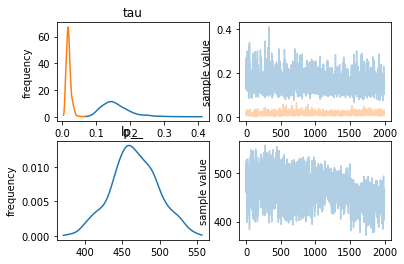

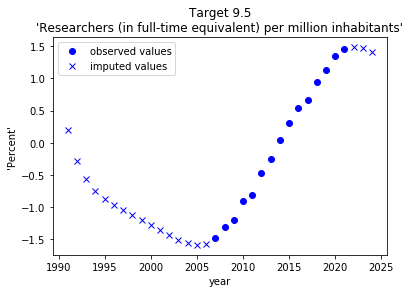

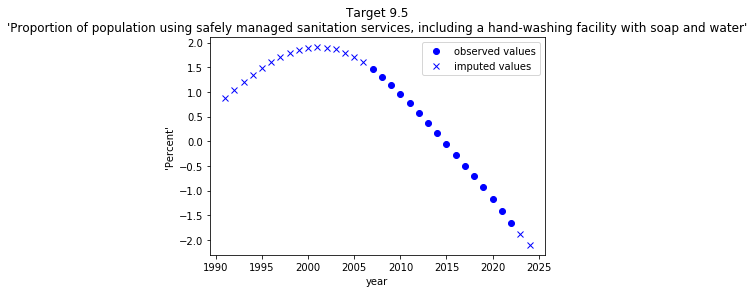

('15.4', '9.5')
Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.81    0.02   0.11  -0.95   -0.9  -0.82  -0.75  -0.56     34   1.15
beta[1,0]     -0.91    0.01    0.1  -1.03  -0.98  -0.93  -0.86  -0.67     55   1.11
beta[0,1]      1.78    0.02   0.11   1.53   1.72    1.8   1.88   1.93     34   1.15
beta[1,1]      1.89    0.02    0.1   1.64   1.84   1.91   1.96   2.01     35   1.12
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]     0.48    0.04   0.46  -0.65    0.2   0.61   0.85   0.99    131   1.02
Omega[0,1]     0.48    0.04   0.46  -0.65    0.2   0.61   0.85   0.99    131   1.02
Omega[1,1]      1.0 1.5e-186.4e-17    1.0    1.0    1.0    1.0    1.0   1952    nan
tau[0]         0.06  6.3e-3   0.04 6.8e-3

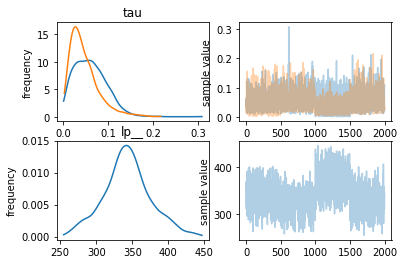

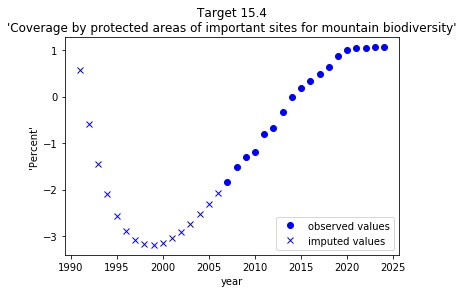

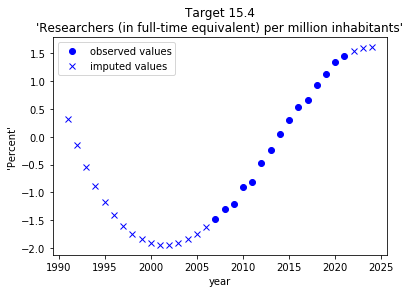

('9.2', '7.1')
Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.03    0.02   0.32  -0.65  -0.25  -0.02   0.18   0.62    420   1.01
beta[1,0]     -0.15    0.04   0.44  -0.94  -0.47  -0.18   0.16   0.71     96   1.03
beta[0,1]      0.76    0.02   0.33   0.13   0.53   0.76   0.98   1.45    237   1.01
beta[1,1]       0.2    0.07   0.62  -1.13  -0.18   0.24   0.61   1.22     71   1.05
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]     0.43    0.06    0.5  -0.76   0.11   0.56   0.86   0.99     75   1.06
Omega[0,1]     0.43    0.06    0.5  -0.76   0.11   0.56   0.86   0.99     75   1.06
Omega[1,1]      1.0 1.5e-186.7e-17    1.0    1.0    1.0    1.0    1.0   2000    nan
tau[0]         0.58    0.02   0.18   0.23 

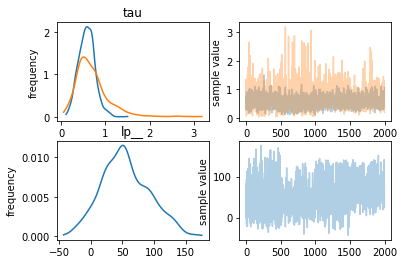

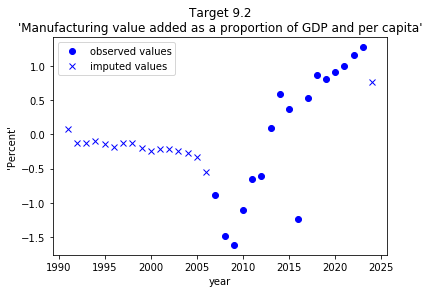

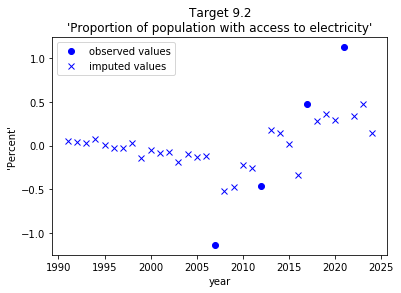

('17.8', '6.2')
Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]      -0.9    0.01   0.09  -1.08  -0.96  -0.91  -0.85  -0.72     59   1.11
beta[1,0]     -1.01  4.3e-3   0.03  -1.06  -1.02  -1.01  -0.99  -0.95     35    1.1
beta[0,1]      1.87    0.02   0.09    1.7   1.81   1.87   1.93   2.04     30   1.13
beta[1,1]       2.0  4.5e-3   0.03   1.94   1.98    2.0   2.01   2.05     34    1.1
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]    -0.53    0.04   0.28  -0.92  -0.74  -0.59  -0.37    0.1     45   1.09
Omega[0,1]    -0.53    0.04   0.28  -0.92  -0.74  -0.59  -0.37    0.1     45   1.09
Omega[1,1]      1.0 1.5e-186.6e-17    1.0    1.0    1.0    1.0    1.0   2000    nan
tau[0]         0.08  6.9e-3   0.02   0.04

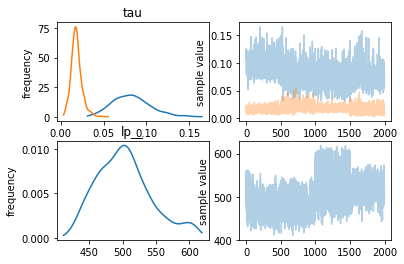

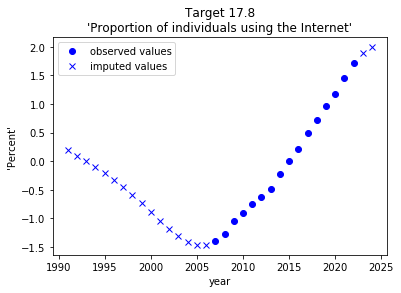

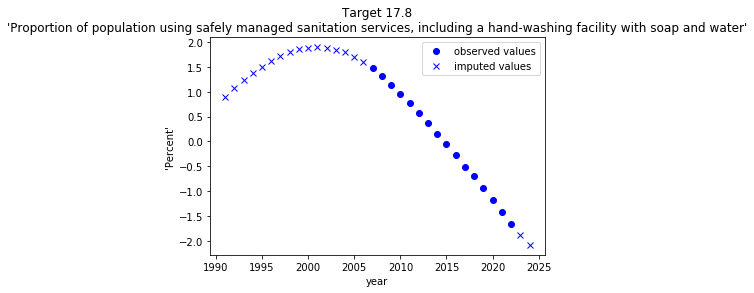

('9.c', '9.5')
Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.25    0.03   0.34  -0.81  -0.49   -0.3  -0.03   0.46    167   1.02
beta[1,0]     -0.93  9.7e-3   0.09  -1.05  -0.99  -0.95  -0.89   -0.7     87   1.07
beta[0,1]      1.05    0.03   0.32   0.34   0.85   1.09   1.27   1.62    148   1.02
beta[1,1]       1.9    0.01    0.1   1.65   1.85   1.93   1.97   2.02     66   1.08
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]     0.19    0.04   0.52  -0.79  -0.21   0.26   0.63   0.95    163   1.01
Omega[0,1]     0.19    0.04   0.52  -0.79  -0.21   0.26   0.63   0.95    163   1.01
Omega[1,1]      1.0 1.9e-187.4e-17    1.0    1.0    1.0    1.0    1.0   1574    nan
tau[0]         0.51  5.4e-3    0.1   0.34 

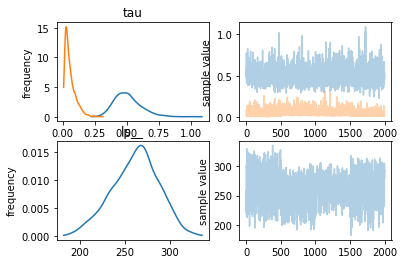

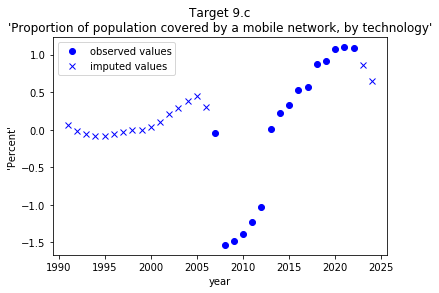

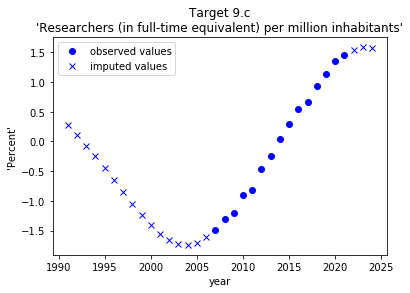

('3.3', '9.5')


In [ ]:
for pair in corrPairs:
    targetx = pair[0]
    targety = pair[1]

    # prepare input data
    inData = prepareInputData(final_t, targetx, targety)
    print(pair)

    # run inference using MCMC sampling
    fit = sm.sampling(data=inData, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
    print(fit)
    
    # what do we actually want to show? sigma and tau are performance measurements.
    fit.plot(["tau","lp__"]) # take vars from temporal model
    plt.show()

    samples = fit.extract(permuted=True)
    
    # get values for plots
    # convert indices back to year values
    ix_mis1 = inData['ix_mis1']+startyear
    ix_mis2 = inData['ix_mis2']+startyear
    ix_obs1 = inData['ix_obs1']+startyear
    ix_obs2 = inData['ix_obs2']+startyear
    
    y_mis1 = samples['y_mis1'].mean(axis=0)
    y_mis2 = samples['y_mis2'].mean(axis=0)
    y_obs1 = inData['y_obs1']
    y_obs2 = inData['y_obs2']
    
    
    # define title and labels from original dataframe
    y1_df = merged_df[merged_df['Target']==pair[0]]
    y2_df = merged_df[merged_df['Target']==pair[1]]
    y1_title = 'Target '+pair[0]+'\n'+str(y1_df['Indicator Description'].values).replace('[','').replace(']','')
    y1_label = str(y1_df['Unit'].values).replace('[','').replace(']','')
    y2_title = 'Target '+pair[0]+'\n'+str(y2_df['Indicator Description'].values).replace('[','').replace(']','')
    y2_label = str(y2_df['Unit'].values).replace('[','').replace(']','')
    
    # plot with imputed values of target 1
    plt.plot(ix_obs1, y_obs1, "bo")
    plt.plot(ix_mis1, y_mis1, "bx")
    plt.title(y1_title)
    plt.legend(["observed values","imputed values"])
    plt.xlabel('year')
    plt.ylabel(y1_label)
    plt.show()
    
    # plot with imputed values of target 2
    plt.plot(ix_obs2, y_obs2, "bo")
    plt.plot(ix_mis2, y_mis2, "bx")
    plt.title(y2_title)
    plt.legend(["observed values", "imputed values"])
    plt.xlabel('year')
    plt.ylabel(y2_label)
    plt.show()

## Open questions: What we haven't understood so far

- Omega[1,0] is a value of Omega that gives us the correlation between Target 1 and 2. What kind of correlation measure is it? How can it be different/lower from our previously found Pearson r?


## Prospect: What we can do next
- use inferred values and/or identified relations to make predictions for the future based on assumptions of the development of one indicator
- find "plan of action" to improve one target/reach one target